In [1]:
##Part 1 Installl libararies 
#Run the following line if any of the following libraries are not installed
!pip install numpy pandas seaborn statsmodels matplotlib 

In [2]:
##Part 2: Loading necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re
from itertools import product
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_cluster
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from linearmodels.panel import RandomEffects
from IPython.display import FileLink

In [6]:
##Part 3: Loading the data

#Create function to download a file from a URL
#Own dataset on monarchies, subnational monarchies, (former) communist countries and commonwealth realms
owndata_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/Thesis%20data%20start%20csv.csv"
vdem_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/vdem_adjusted.csv"
WB_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/WB-adjusted.csv"
WVS1_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/WVS_1_adjusted.csv"
WVS2_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/WVS_2_adjusted.csv"
EVS_url = "https://github.com/TiSEM/monarchy_thesis/raw/refs/heads/main/EVS_adjusted.csv"

#Read the files 
own_data = pd.read_csv(owndata_url)
WB = pd.read_csv(WB_url)
vdem = pd.read_csv(vdem_url)
WVS1 = pd.read_csv(WVS1_url, header=None) 
WVS2 = pd.read_csv(WVS2_url, header=None)
EVS = pd.read_csv(EVS_url)

# Assign first row of the WVS and EVS-datasets as the column names
WVS1.columns = WVS1.iloc[0]  
WVS2.columns = WVS2.iloc[0]


#Merge the WVS-datasets toegether to create one WVS-dataset
WVS = WVS1.merge(WVS2, on=['year', 'respondent', 'country'], how='outer')
WVS = WVS[1:] 
WVS.reset_index(drop=True, inplace=True)

#Integrate the WVS and EVS datasets
WVS_EVS = pd.concat([WVS, EVS], ignore_index=True).drop_duplicates()

#Drop the 'freedom_feeling' and 'sub_monarchy_region' variables and empty column
WVS_EVS = WVS_EVS.drop(columns=['freedom_feeling', 'sub_monarchy_region'])
WB = WB.drop(columns={'Unnamed: 9'})    

print('Loaded self-created dataset')
print('Loaded World Bank dataset')
print('Loaded Varieties of Democracy dataset previously adjusted to relevant variables')
print('Loaded World Values Survey and European Values Survey datasets previously adjusted and on an individual level')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3148\3237252943.py:16: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  WVS1 = pd.read_csv(WVS1_url, header=None)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3148\3237252943.py:17: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  WVS2 = pd.read_csv(WVS2_url, header=None)


Loaded self-created dataset
Loaded World Bank dataset
Loaded Varieties of Democracy dataset previously adjusted to relevant variables
Loaded World Values Survey and European Values Survey datasets previously adjusted and on an individual level


In [7]:
##Part 4: Editing the data for unification and interpretability

##Update dataset1: Own dataset
#Change into country-year observations
#Define range of years
years = range(1980, 2024)

#Obtain all country-year combinations in a dataframe
country_year_pairs_own = pd.DataFrame(list(product(own_data['Country Name'], years)), columns=['Country Name', 'year'])
own_data_full = country_year_pairs_own.merge(own_data, on='Country Name', how='left')

#Variables to keep
own_variables = ['year', 'Country Name', 'National monarchy', '(former) Communist', 'CRW binary']
own_data_full = own_data_full[own_variables]

#Adjust variable names
own_data_full = own_data_full.rename(columns={'CRW binary': 'cwr', 'Country Name': 'country', 'National monarchy': 'monarchy', '(former) Communist': 'communism'})
                                              
#Adjust dataset for variables changing over time: Barbados, Fiji, Mauritius, Nepal and Zimbabwe
own_data_full.loc[(own_data_full['country'] == 'Barbados') & (own_data_full['year'] <= 2021), ['monarchy', 'cwr']] = [1, 1]
own_data_full.loc[(own_data_full['country'] == 'Barbados') & (own_data_full['year'] > 2021), ['monarchy', 'cwr']] = [0, 0]
own_data_full.loc[(own_data_full['country'] == 'Fiji') & (own_data_full['year'] <= 1987), ['monarchy', 'cwr']] = [1, 1]
own_data_full.loc[(own_data_full['country'] == 'Fiji') & (own_data_full['year'] > 1987), ['monarchy', 'cwr']] = [0, 0]
own_data_full.loc[(own_data_full['country'] == 'Mauritius') & (own_data_full['year'] <= 1992), ['monarchy', 'cwr']] = [1, 1]
own_data_full.loc[(own_data_full['country'] == 'Mauritius') & (own_data_full['year'] > 1992), ['monarchy', 'cwr']] = [0, 0]
own_data_full.loc[(own_data_full['country'] == 'Nepal') & (own_data_full['year'] <= 2008), 'monarchy'] = 1
own_data_full.loc[(own_data_full['country'] == 'Nepal') & (own_data_full['year'] > 2008), 'monarchy'] = 0
own_data_full.loc[(own_data_full['country'] == 'Zimbabwe') & (own_data_full['year'] <= 1980), ['monarchy', 'cwr']] = [1, 1]
own_data_full.loc[(own_data_full['country'] == 'Zimbabwe') & (own_data_full['year'] > 1980), ['monarchy', 'cwr']] = [0, 0]

##Update dataset2: World Bank dataset
#Rename the variables for interpretability
WB = WB.rename(columns = {'Country Name': 'country', 'Time': 'year', 'Population, total': 'population','GDP per capita, PPP (constant 2021 international $)': 'gdp_pc',
                            'Inflation, consumer prices (annual %)': 'inflation','Political Stability and Absence of Violence/Terrorism: Estimate': 'political_stability',
                            'Life expectancy at birth, total (years)': 'life_expectancy', 'Unemployment, total (% of total labor force) (modeled ILO estimate) ': 'unemployment',
                            'Trade (% of GDP)': 'trade'})

##Update dataset3: Vdem
#Delete unnecessary variables and observations before 1981
vdem_variables = ['country', 'year', 'liberal_democracy', 'corruption', 'society_camps','socialclass_equality']
vdem = vdem[vdem_variables]
vdem = vdem[vdem['year'] >= 1980]

#All datasets: WVS/EVS, WB, Vdem and own dataset
#Adjust country names for unification and to prepare for merge
# Sort datasets by 'country' and then by 'year'
own_data_full = own_data_full.sort_values(by=['country', 'year'])
WVS_EVS = WVS_EVS.sort_values(by=['country', 'year', 'respondent'])
WB = WB.sort_values(by=['country', 'year'])
vdem = vdem.sort_values(by=['country', 'year'])

#Define the non-recognized countries in the dataset
excluded_countries = ['Bermuda','Hong Kong', 'Macau', 'North Ireland', 'Palestine', 'Puerto Rico', 'Cayman Islands', 'Zanzibar', 'Greenland', 
                      'German Democratic Republic', 'Gibraltar', 'Palestine/Gaza', 'Palestine/West Bank', 'Somaliland', 'South Yemen', 'Taiwan']

# Filter these countries out of each dataset
own_data_full = own_data_full[~own_data_full['country'].isin(excluded_countries)]
WVS_EVS = WVS_EVS[~WVS_EVS['country'].isin(excluded_countries)]
WB = WB[~WB['country'].isin(excluded_countries)]
vdem = vdem[~vdem['country'].isin(excluded_countries)]

#Adjust country names of the dataset for unification
updated_countries = {'Azerbaijan': 'Azerbijan', 'Bahamas, The': 'Bahamas', 'Brunei Darussalam': 'Brunei', 'Burma/Myanmar': 'Myanmar', 'Cape Verde': 'Cabo Verde', 
                     'Tunisia': 'Tunesia', 'Congo, Dem. Rep.': 'Congo Kinshasa', 'Congo, Rep.': 'Congo Brazzaville', "Cote d'Ivoire": 'Ivory Coast', 
                     'Democratic Republic of the Congo': 'Congo Kinshasa', 'Republic of the Congo': 'Congo Brazzaville', 'Egypt, Arab Rep.': 'Egypt', 
                     'Gambia, The': 'Gambia', 'Iran, Islamic Rep.': 'Iran', "Korea, Dem. People's Rep.": 'North Korea', 'Korea, Rep.': 'South Korea', 
                     'Kyrgyz Republic': 'Kyrgyzstan', 'Lao PDR': 'Laos', 'Micronesia, Fed. Sts.': 'Micronesia', 'Republic of Congo': 'Congo Brazzaville', 
                     'Russian Federation': 'Russia', 'Saint Kitts and Nevis': 'St. Kitts and Nevis', 'Saint Lucia': 'St. Lucia', 
                     'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines', 'Slovak Republic': 'Slovakia', 'Syrian Arab Republic': 'Syria', 
                     'The Gambia': 'Gambia', 'Türkiye': 'Turkiye', 'UAE': 'United Arab Emirates', 'United States of America': 'United States', 'Venezuela, RB': 'Venezuela', 
                     'Viet Nam': 'Vietnam', 'Yemen, Rep.': 'Yemen'}

#Update the country names
own_data_full['country'] = own_data_full['country'].replace(updated_countries)
WVS_EVS['country'] = WVS_EVS['country'].replace(updated_countries)
WB['country'] = WB['country'].replace(updated_countries)
vdem['country'] = vdem['country'].replace(updated_countries)

#Change objects to floats
#Define columns per dataset that need to be numerical
WVS_EVS_numeric = ['year', 'happiness', 'people_trustful','proud_nationality', 'sex', 'age', 'life_satisfaction', 'health', 'god_important', 'income_class',
                    'full_employed', 'unemployed','marital_relationship']
WB_numeric = ['year', 'population', 'gdp_pc', 'inflation', 'political_stability', 'life_expectancy', 'unemployment', 'trade']
own_data_numeric = ['year', 'monarchy', 'communism', 'cwr']

#Change datatype from objects to floats 
for var in WVS_EVS_numeric : 
    WVS_EVS[var] = pd.to_numeric(WVS_EVS[var], errors='coerce')
for var in WB_numeric : 
    WB[var] = pd.to_numeric(WB[var], errors='coerce')
for var in own_data_numeric : 
    own_data_full[var] = pd.to_numeric(own_data_full[var], errors='coerce')

#Dataset 4: WVS/EVS
#Change the scale of some WVS/EVS-variables for interpretability
adjust_interpret = ['happiness', 'proud_nationality', 'people_trustful', 'health']
for var in adjust_interpret:
    max_value = WVS_EVS[var].max() 
    WVS_EVS[var] = max_value - WVS_EVS[var] + 1

#Adjust to make binary
WVS_EVS['sex'] = WVS_EVS['sex'] - 1
WVS_EVS['people_trustful'] = WVS_EVS['people_trustful'] - 1

#Display the head of the final individual datasets
dataset_dict = {"own_data": own_data_full,"WVS/EVS": WVS_EVS,"WB": WB,"vdem": vdem}
for name, dataset in dataset_dict.items():
    print(f"\nThe upper part of the {name}-dataset looks like: \n{dataset.head()}")


The upper part of the own_data-dataset looks like: 
   year      country  monarchy  communism  cwr
0  1980  Afghanistan         0        1.0    0
1  1981  Afghanistan         0        1.0    0
2  1982  Afghanistan         0        1.0    0
3  1983  Afghanistan         0        1.0    0
4  1984  Afghanistan         0        1.0    0

The upper part of the WVS/EVS-dataset looks like: 
        year  country      respondent  happiness  people_trustful  \
429212  2008  Albania  200800800001.0        3.0              0.0   
429213  2008  Albania  200800800002.0        3.0              0.0   
429214  2008  Albania  200800800003.0        2.0              0.0   
429215  2008  Albania  200800800004.0        2.0              1.0   
429216  2008  Albania  200800800005.0        3.0              0.0   

        proud_nationality  sex   age  life_satisfaction  health  \
429212                NaN  1.0  56.0                6.0     3.0   
429213                3.0  1.0  19.0                8.0     5.0 

In [8]:
##Part 5: Missing data inspection 

#Define function to check missing data per variable, country and year
def missing_data(df, country_column='country', year_column='year'):
    #Calculate missing percentages per variable
    missing_percentage_per_variable = (df.isnull().mean() * 100).rename("missing percentage")
    missing_by_variable_sorted = missing_percentage_per_variable.sort_values(ascending=False).to_frame()
    missing_by_variable_sorted.index.name = "variable"

    #Calculate missing percentages per country
    missing_percentage_per_country = (df.groupby(country_column).apply(lambda x: x.isnull().mean() * 100))
    missing_by_country_sorted = missing_percentage_per_country.mean(axis=1).sort_values(ascending=False).to_frame(name="missing percentage")
    missing_by_country_sorted.index.name = country_column

    #Display the results
    print("Missing Data Percentage By Variable (Sorted):\n", round(missing_by_variable_sorted, 1))
    print("\nMissing Data Percentage By Country (Sorted):\n", round(missing_by_country_sorted, 1))

#Call missing data function
print('World Bank dataset')
missing_data(df=WB) #function previously defined
print('Vdem dataset')
missing_data(df=vdem) #function previously defined
print('Integrated World Values Survey and European Values Survey dataset')
missing_data(df=WVS_EVS) #function previously defined

World Bank dataset
Missing Data Percentage By Variable (Sorted):
                      missing percentage
variable                               
political_stability                44.0
unemployment                       31.2
gdp_pc                             26.8
trade                              22.1
inflation                          20.1
life_expectancy                     4.4
country                             0.0
year                                0.0
population                          0.0

Missing Data Percentage By Country (Sorted):
                     missing percentage
country                               
Monaco                            61.4
Liechtenstein                     53.0
Andorra                           51.8
San Marino                        49.2
Tuvalu                            41.7
...                                ...
Dominican Republic                10.4
Norway                            10.4
Denmark                           10.4
Niger             

In [9]:
##Part 6: Merging three countrylevel datasets together, deleting unnecessary variables and KNN-imputate their missing data 

#Merge three countrybased datasets iteratively
merged_data_country = own_data_full.merge(WB, on=["year", "country"], how="outer").merge(vdem, on=["year", "country"], how="outer")

#Create dataset with only the numeric variables
data_country_numeric = merged_data_country.drop(columns=['country'])

#Function to fill missing datapoints from certain columns by K-Nearest Neighbors (KNN) imputation 
def KNN_imputation(df, n_neighbors=5):
    
    #Scale data 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(data_scaled, index=df.index, columns=df.columns)
    
    #KNN-impute data
    imputer = KNNImputer(n_neighbors=n_neighbors)
    data_scaled_imputed= imputer.fit_transform(df_scaled)
    df_scaled_imputed = pd.DataFrame(data_scaled_imputed, index=df.index, columns=df.columns)

    #Scale inverse data
    data_imputed = scaler.inverse_transform(df_scaled_imputed)
    df_imputed = pd.DataFrame(data_imputed, index=df.index, columns=df.columns)

    return df_imputed

#Fill missing datapoints from the countrylevel data
country_data_numeric_KNN = KNN_imputation(df=data_country_numeric) #function previously defined
data_country_KNN = merged_data_country.copy()
data_country_KNN.loc[:,country_data_numeric_KNN.columns] = country_data_numeric_KNN
data_country_KNN.loc[:, country_data_numeric_KNN.columns] = data_country_KNN.loc[:, country_data_numeric_KNN.columns].round(6)
data_country_KNN['monarchy'] = data_country_KNN['monarchy'].abs()

#Change 'year' variable to object
data_country_KNN['year'] = data_country_KNN['year'].astype('object')

In [10]:
##Part 7: Handle missing data in the WVS-dataset and merge with country-based dataset

#Create function to fill in missing datapoints based on country-year means
def country_year_mean_imputation(df, impute_column, country_column='country', year_column='year'):
    df[impute_column] = df.groupby([country_column, year_column])[impute_column].transform(lambda x: x.fillna(x.mean()))
    return df

#Impute missing data points with country-year means
for var in WVS_EVS_numeric:
    WVS_EVS = country_year_mean_imputation(df=WVS_EVS, impute_column=var) #function previously defined

#Create variable 'time'
WVS_EVS['time'] = WVS_EVS['year'] - 1981
WVS_EVS['time'] = pd.to_numeric(WVS_EVS['time'], errors='coerce')
#Change 'year' variable to object
WVS_EVS['year'] = WVS_EVS['year'].astype('object')

# Create subset to KNN-impute on
selected_countries = ["Israel", "Kuwait", "Greece", "Qatar", "Saudi Arabia", "Italy"]
subset_df = WVS_EVS[WVS_EVS['country'].isin(selected_countries)].copy()
subset_df_numeric = subset_df.select_dtypes(include=[np.number])

#Fill dataset with KNN-imputer
Isreal_Kuwait_filled_numeric = KNN_imputation(df=subset_df_numeric)

#Update subset first
subset_df.update(Isreal_Kuwait_filled_numeric)
#Then update the entire dataframe
WVS_EVS.update(subset_df)

#Merge WVS/EVS dataset with country-level dataset
merged_data= WVS_EVS.merge(data_country_KNN, on=['year', 'country'], how='outer')

print('Successfully merged datasets, the missing datapoints now are distributed as:')
missing_data(df=merged_data) #function previously defined


Successfully merged datasets, the missing datapoints now are distributed as:
Missing Data Percentage By Variable (Sorted):
                       missing percentage
variable                                
health                               8.4
god_important                        3.7
income_class                         2.8
sex                                  1.9
happiness                            1.8
proud_nationality                    1.8
age                                  1.7
people_trustful                      1.7
life_satisfaction                    1.5
full_employed                        1.2
marital_relationship                 1.2
unemployed                           1.2
time                                 1.2
respondent                           1.2
gdp_pc                               0.6
society_camps                        0.6
corruption                           0.6
liberal_democracy                    0.6
inflation                            0.6
population     

In [11]:
##Part 8: Handle missing data and create complete dataset

#Drop an observations if a value for 'respondent' is missing
def drop_missing_respondent(df, respondent_column='respondent'):
    cleaned_df = df.dropna(subset=[respondent_column])
    return cleaned_df

#Function to drop observations with missing data
def drop_missing(df, columns=None):
    df_dropped = df.dropna(subset=columns)
    return df_dropped

#Drop observation if value for 'respondent' is missing
data_cleaned = drop_missing_respondent(df=merged_data) #function previously defined

#Drop remaining observations where value is still missing
data_final = drop_missing(df=data_cleaned) #function previously defined

# Create a new dataset with log-transformed variables
data_final_logged = data_final.copy()

#Log-transform the variables population, trade, gdp_pc, inflation and unemployment
variables_to_log = ['population', 'trade', 'gdp_pc']
data_final_logged[variables_to_log] = np.log(data_final_logged[variables_to_log] + 1)
data_final_logged = data_final_logged.rename(columns={'population': 'log_population', 'trade': 'log_trade', 'gdp_pc': 'log_gdp_pc'})

#Define dataset with only the numeric variables
data_logged_numeric = data_final_logged.select_dtypes(include=['number'])
binaries = ['monarchy', 'cwr', 'communism', 'sex', 'full_employed', 'unemployed', 'marital_relationship', 'people_trustful', 'time']
data_logged_numeric_no_binary =data_logged_numeric.drop(columns=binaries)

#Create scaled dataset 
scaler = StandardScaler()
final_numeric_scaled = scaler.fit_transform(data_logged_numeric_no_binary)
data_logged_numeric_scaled = pd.DataFrame(final_numeric_scaled, index=data_logged_numeric_no_binary.index, columns=data_logged_numeric_no_binary.columns)
data_logged_scaled = data_final_logged.copy()
data_logged_scaled.loc[:,data_logged_numeric_no_binary.columns] = data_logged_numeric_scaled

#Create interaction variables for the different monarchy variables and liberal_democracy and a variable for age**2
data_logged_scaled['monarchy_interaction'] = data_logged_scaled['monarchy'] * data_logged_scaled['liberal_democracy']
data_logged_scaled['age2'] = data_logged_scaled['age']**2

#Reorder the columns for both datasets
data_final = data_final[['country', 'year', 'respondent', 'life_satisfaction', 'monarchy', 'cwr', 'time', 'liberal_democracy', 'corruption', 'political_stability', 'gdp_pc', 
                         'unemployment',  'population', 'trade', 'inflation', 'society_camps', 'socialclass_equality', 'life_expectancy', 'communism', 'sex', 'age', 
                         'full_employed', 'unemployed', 'marital_relationship', 'health', 'income_class', 'people_trustful', 'proud_nationality', 'god_important',  'happiness']]

data_logged_scaled = data_logged_scaled[['country', 'year', 'respondent', 'life_satisfaction', 'monarchy', 'monarchy_interaction', 'cwr', 'time', 'liberal_democracy', 'corruption', 
                                         'political_stability', 'log_gdp_pc', 'log_population', 'log_trade', 'inflation', 'unemployment', 'society_camps', 'socialclass_equality', 
                                        'life_expectancy', 'communism', 'sex', 'age', 'age2', 'full_employed', 'unemployed', 'marital_relationship', 'health', 'income_class',
                                        'people_trustful', 'proud_nationality', 'god_important',  'happiness']]

data_dummies = pd.get_dummies(data_logged_scaled['time'], prefix='year').astype(int)
data_dummies.columns = data_dummies.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
data_scal_log_dum = pd.concat([data_logged_scaled, data_dummies], axis=1)


print('Complete dataset is merged together')


Complete dataset is merged together


In [12]:
##Part 9: Display summary statistics of the final dataset

#Calculate average life satisfaction for the different monarchy groups
ls_mean = data_final['life_satisfaction'].mean()
ls_mean_monarchy = data_final.groupby('monarchy')['life_satisfaction'].mean()
ls_mean_cwr = data_final.groupby('cwr')['life_satisfaction'].mean()

#Print summary statistics on the loaded dataset
print(f"\nThe variables in the dataframe now are:\n {data_logged_scaled.columns}")
      
print(f"\nThe number of countries in this merged dataset is:{ len(data_final['country'].unique())}")
print(f"\nThese countries are: \n {sorted(data_final['country'].unique())}")
specific_countries = ['monarchy', 'cwr', 'communism']
for var in specific_countries:
    filtered_var = data_final[data_final[var] != 0]
    print(f"\nThe number of countries in this dataset with {var} is:{ len(filtered_var['country'].unique())}")

#Display specifications for target variable 'life satisfaction' over monarchy-variables: 'monarchy', 'cwr' and 'subnational monarchies'
print("\n\nThe variable life satisfaction runs from  1 - 10 with 10 being completely satisfied with your life.")
print("The variable 'life satisfaction' is distributed over the monarchy-values as:")     
print(f"\nAverage life satisfaction overall: {round(ls_mean, 2)}")

print("\nAverage life satisfaction over monarchies:")
for monarchy, avg_ls in ls_mean_monarchy.items():
    label = "With Monarchy" if monarchy == 1 else "Without Monarchy"
    print(f"{label}: {avg_ls:.2f}")

print("\nAverage life satisfaction over cwr:")
for cwr, avg_ls in ls_mean_cwr.items():
    label = "With commonwealth realm" if cwr == 1 else "Without commonwealth realm"
    print(f"{label}: {avg_ls:.2f}")

#Display number of observations over the different monarchy variables
print('\nNumber of observations per value')
print(data_final['monarchy'].value_counts())
print(data_final['cwr'].value_counts())

#Display description of entire dataset
print('\nThe summary statistics of all variables non-scaled are as follows:')
print(data_final.describe())


The variables in the dataframe now are:
 Index(['country', 'year', 'respondent', 'life_satisfaction', 'monarchy',
       'monarchy_interaction', 'cwr', 'time', 'liberal_democracy',
       'corruption', 'political_stability', 'log_gdp_pc', 'log_population',
       'log_trade', 'inflation', 'unemployment', 'society_camps',
       'socialclass_equality', 'life_expectancy', 'communism', 'sex', 'age',
       'age2', 'full_employed', 'unemployed', 'marital_relationship', 'health',
       'income_class', 'people_trustful', 'proud_nationality', 'god_important',
       'happiness'],
      dtype='object')

The number of countries in this merged dataset is:111

These countries are: 
 ['Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbijan', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuad

In [33]:
##Part 10: Display dataparts
#To check observations per country
country_input = input("Enter country name:")
n_input = int(input("Enter number of observations to display:"))

(data_final[data_final['country'].str.startswith(country_input)]).head(n_input)

,country,year,respondent,life_satisfaction,monarchy,cwr,time,liberal_democracy,corruption,political_stability,...,age,full_employed,unemployed,marital_relationship,health,income_class,people_trustful,proud_nationality,god_important,happiness
56023,Belgium,1981,19810560001.0,9.0,1.0,0.0,0.0,0.786,0.041,1.334121,...,53.0,1.0,0.0,0.0,3.0,3.0,0.0,3.000000,5.0,3.0
56024,Belgium,1981,19810560002.0,9.0,1.0,0.0,0.0,0.786,0.041,1.334121,...,30.0,1.0,0.0,1.0,5.0,6.0,0.0,3.000000,6.0,4.0
56025,Belgium,1981,19810560003.0,3.0,1.0,0.0,0.0,0.786,0.041,1.334121,...,61.0,0.0,1.0,0.0,2.0,1.0,1.0,2.000000,4.0,2.0
56026,Belgium,1981,19810560004.0,9.0,1.0,0.0,0.0,0.786,0.041,1.334121,...,60.0,0.0,0.0,1.0,5.0,3.0,1.0,3.002026,8.0,4.0
56027,Belgium,1981,19810560005.0,9.0,1.0,0.0,0.0,0.786,0.041,1.334121,...,60.0,0.0,0.0,1.0,5.0,2.0,1.0,3.000000,8.0,4.0


In [85]:
##Part 11: Data inspection functions
#Create function that is called later on to display information on the dataset

#Function calculating the correlation and VIF, displaying boxplots for all variables and identifying outliers
def corr_and_VIF(df_scaled, df, target):

    #Calculate the correlation matrix
    correlation_matrix = df_scaled.corr()

    #Display corresponding heatmap
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix of scaled data")
    plt.show()

    #Caluclate the points where the absolute correlation is larger than 0.7
    filtered_correlation_matrix = correlation_matrix.where((correlation_matrix.abs() > 0.7) & (correlation_matrix != 1))
    # Drop rows and columns where all values are NaN
    filtered_correlation_matrix = filtered_correlation_matrix.dropna(how='all').dropna(axis=1, how='all')
    #Display corresponding heatmap of the absolute values larger than 0.7
    plt.figure(figsize=(5, 3))
    sns.heatmap(filtered_correlation_matrix, cmap="coolwarm", linewidths=0.2)
    plt.title("Correlation Matrix with absolute correlation larger than 0.7")
    plt.show()
    
    # Select only the predictor variables (exclude the target variable)
    X = df_scaled.drop(columns=[target])  

    # Add a constant term as an intercept
    X = sm.add_constant(X)

    # Calculate and display VIF for each predictor variable
    vif_scaled_data = pd.DataFrame()
    vif_scaled_data['Feature'] = X.columns
    vif_scaled_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_scaled_data)
    
    #Show distribution plots for all variables
    # Calculate the number of rows and columns for subplots
    num_plots = len(df.columns)
    cols = 3
    rows = (num_plots + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    # Loop through columns to create individual plot distributions
    for i, col in enumerate(df.columns):
        if col != 'life_satisfaction':  
            sns.histplot(df[col], kde=True, ax=axes[i])  
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_ylabel('Frequency')
            axes[i].set_xlabel(col)

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    #Show scatterplots of all variables with 'life_satisfaction'
    # Variables to iterate (exclude 'life_satisfaction')
    columns_to_iterate = df.loc[:, df.columns != 'life_satisfaction']
    num_plots = len(columns_to_iterate.columns)
    cols = 3
    rows = (num_plots + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    # Loop through columns and plot scatterplots
    for i, col in enumerate(columns_to_iterate):
        # Aggregate data: count occurrences of (variable, happiness) pairs
        aggregated = df.groupby([col, 'life_satisfaction']).size().reset_index(name='count')
    
        # Plot scatterplot on the current axis
        sns.scatterplot(x=col, y='life_satisfaction', size='count', sizes=(5, 450), data=aggregated, legend=False, ax=axes[i])
        axes[i].set_title(f'Life satisfaction vs {col}', fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Life satisfaction')

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    #Detect and give summary of outliers
    q1 = df_scaled.quantile(0.25) 
    q3 = df_scaled.quantile(0.75) 
    iqr = q3 - q1
    outliers = (df_scaled < (q1 - 1.5 * iqr)) | (df_scaled > (q3 + 1.5 * iqr))
    outlier_counts = outliers.sum()
    total_observations = len(df_scaled)
    relative_outliers = ((outlier_counts / total_observations) * 100).round(1)
    outlier_summary = pd.DataFrame({'Variable': outlier_counts.index, 'Outlier count': outlier_counts.values, 'Relative outliers (%)': relative_outliers.values})
    print("\nSummary of outliers per variable:")
    print(outlier_summary)

print("Loaded #Part 10: Data inspection functions")

Loaded #Part 10: Data inspection functions



Overview of the data distribution over countries and years


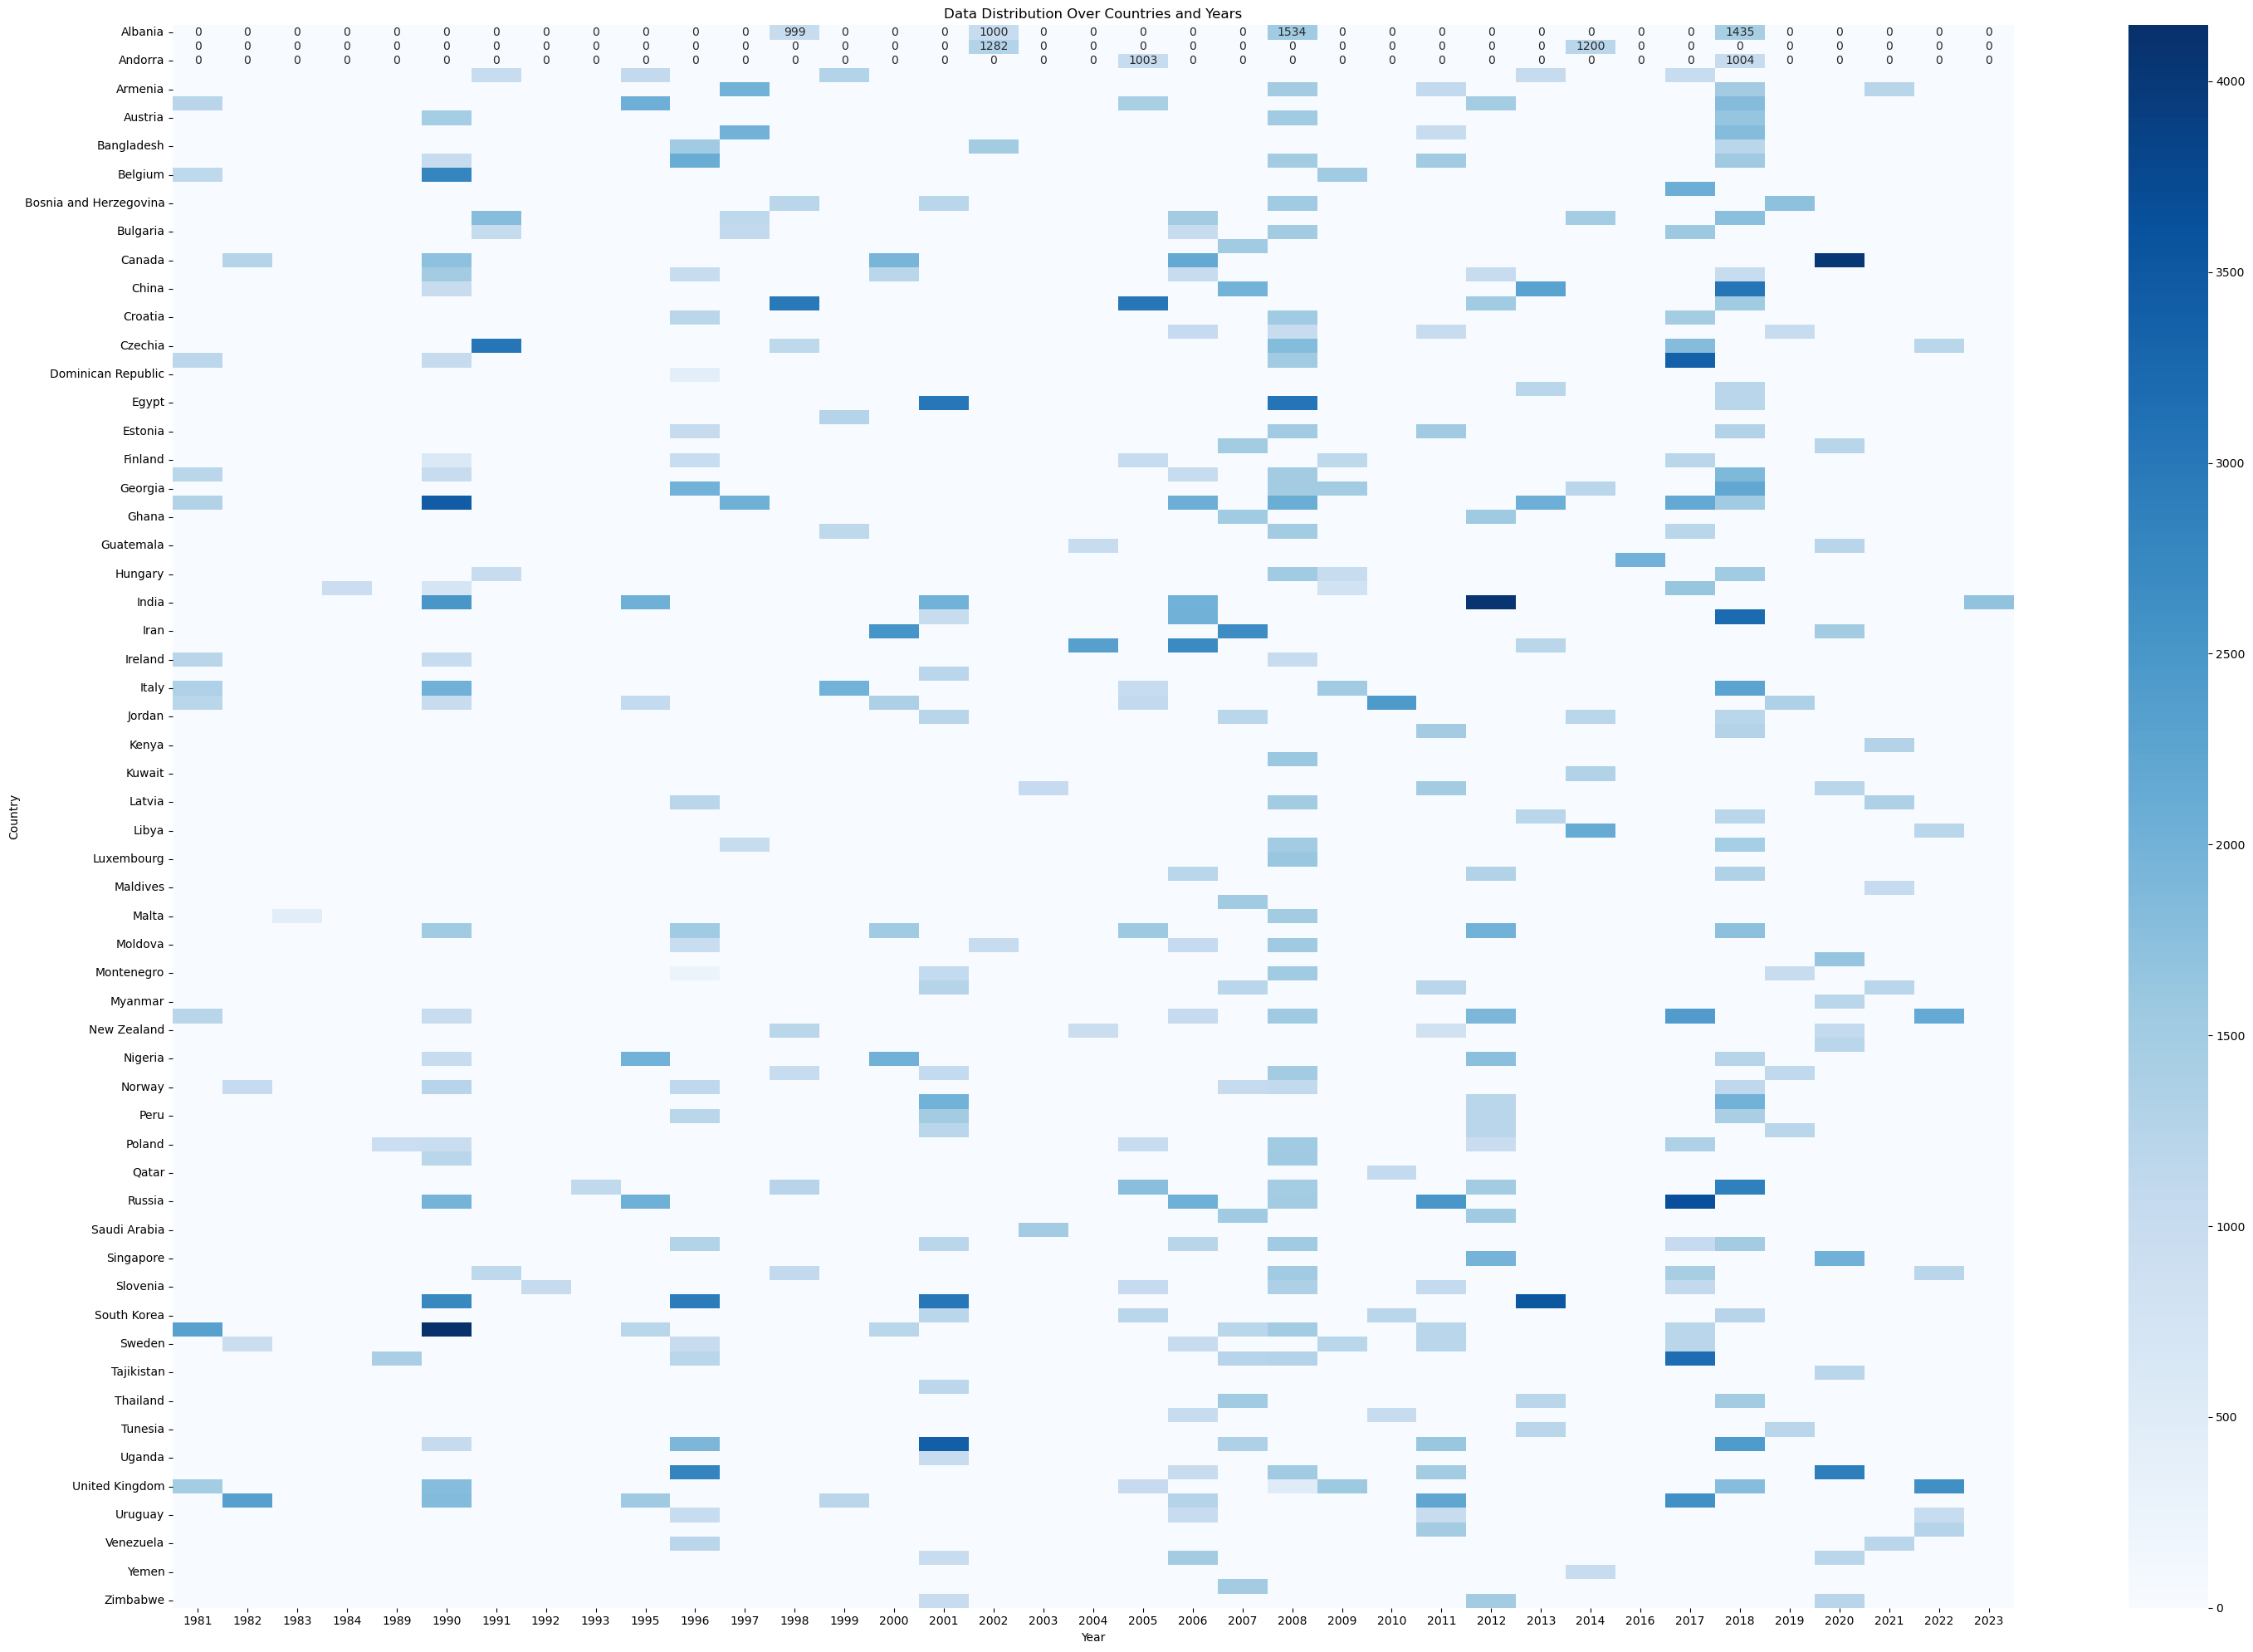

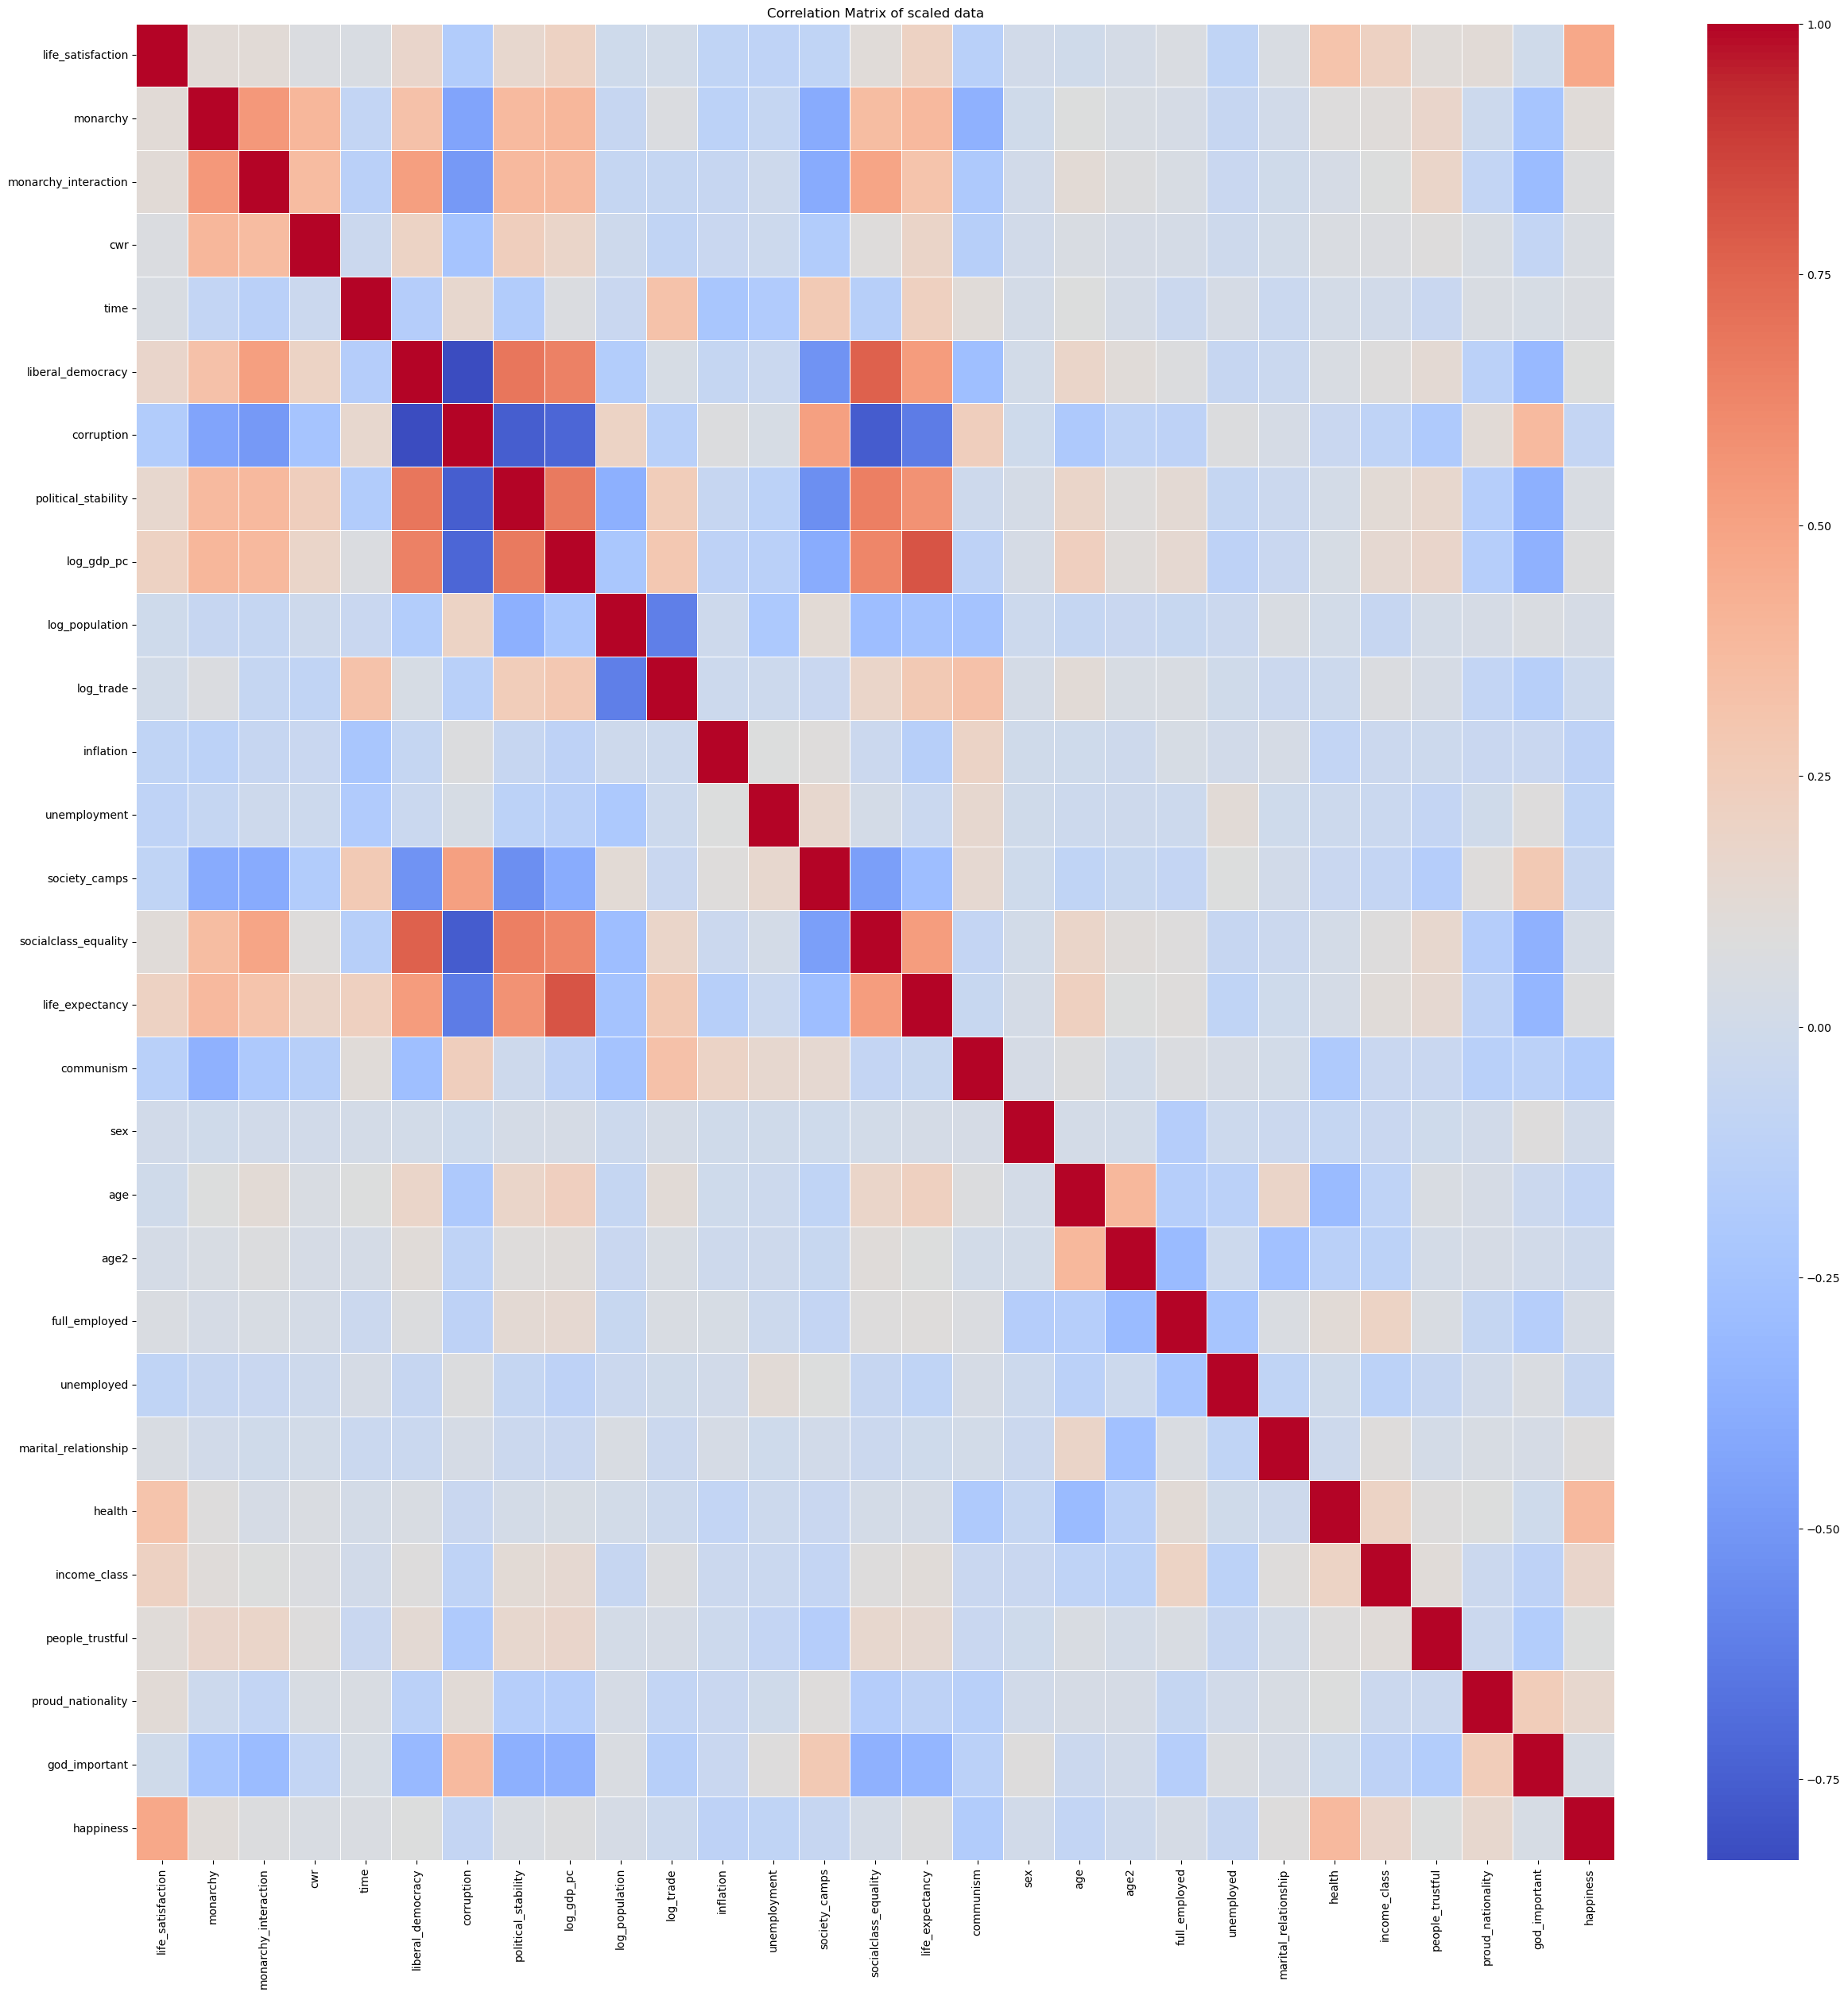

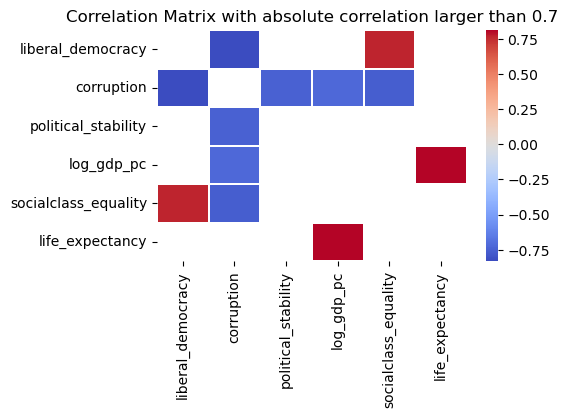

                 Feature        VIF
0                  const  10.787439
1               monarchy   2.185297
2   monarchy_interaction   1.998195
3                    cwr   1.370604
4                   time   1.785238
5      liberal_democracy   4.808841
6             corruption   5.298096
7    political_stability   3.619645
8             log_gdp_pc   4.487222
9         log_population   2.130452
10             log_trade   2.346926
11             inflation   1.156534
12          unemployment   1.334441
13         society_camps   1.775728
14  socialclass_equality   3.413207
15       life_expectancy   3.724324
16             communism   1.953690
17                   sex   1.062622
18                   age   1.608549
19                  age2   1.488155
20         full_employed   1.328604
21            unemployed   1.138363
22  marital_relationship   1.268768
23                health   1.359648
24          income_class   1.145549
25       people_trustful   1.095665
26     proud_nationality   1

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

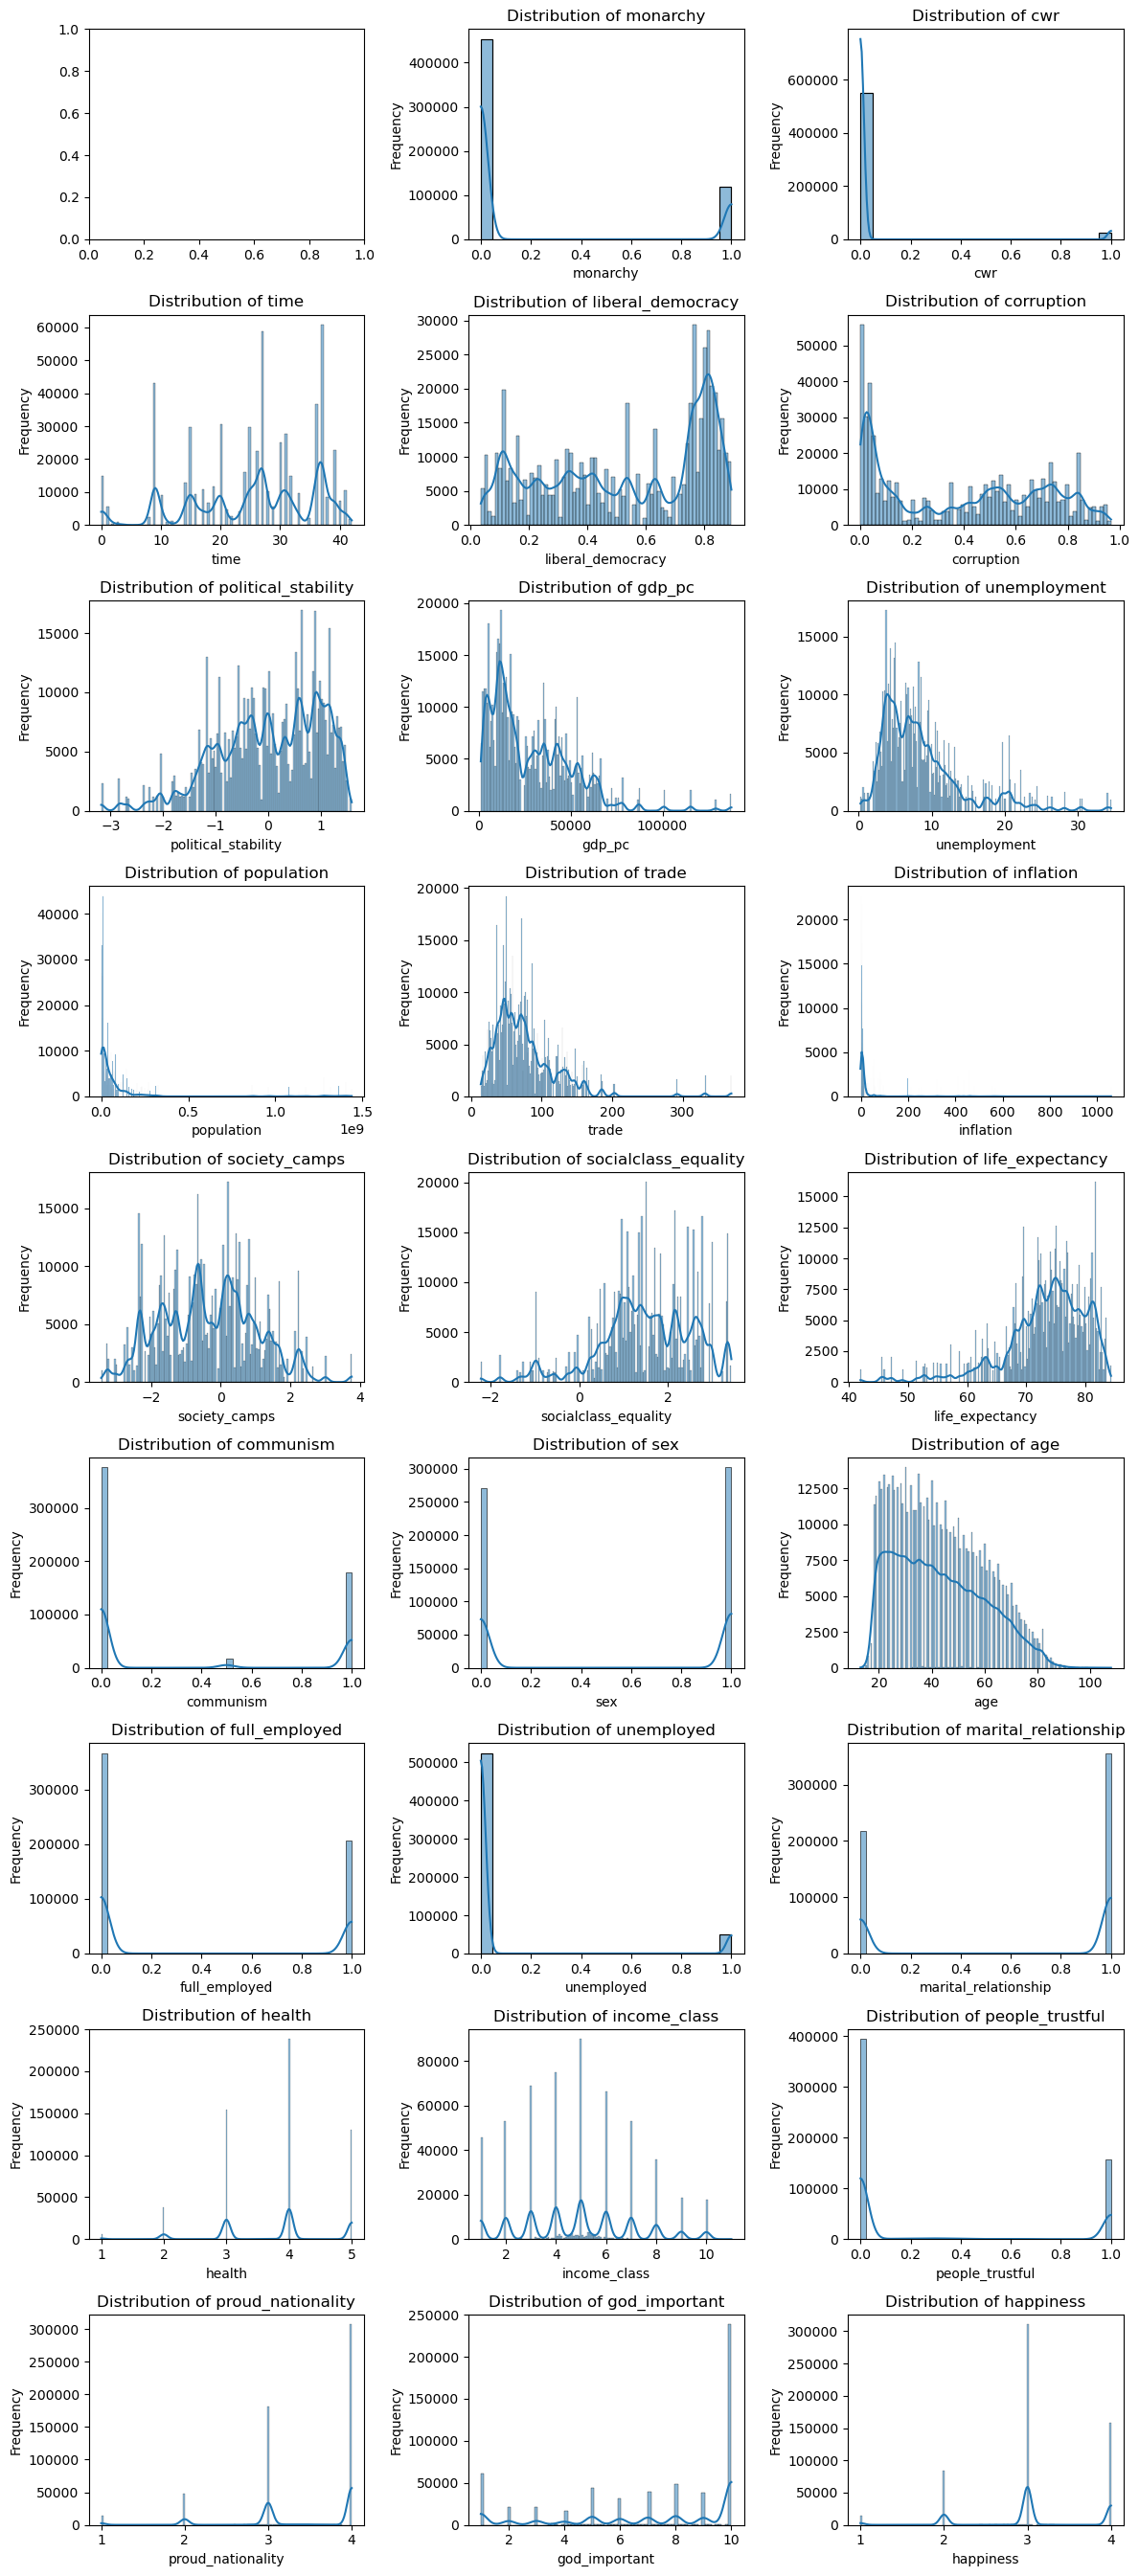

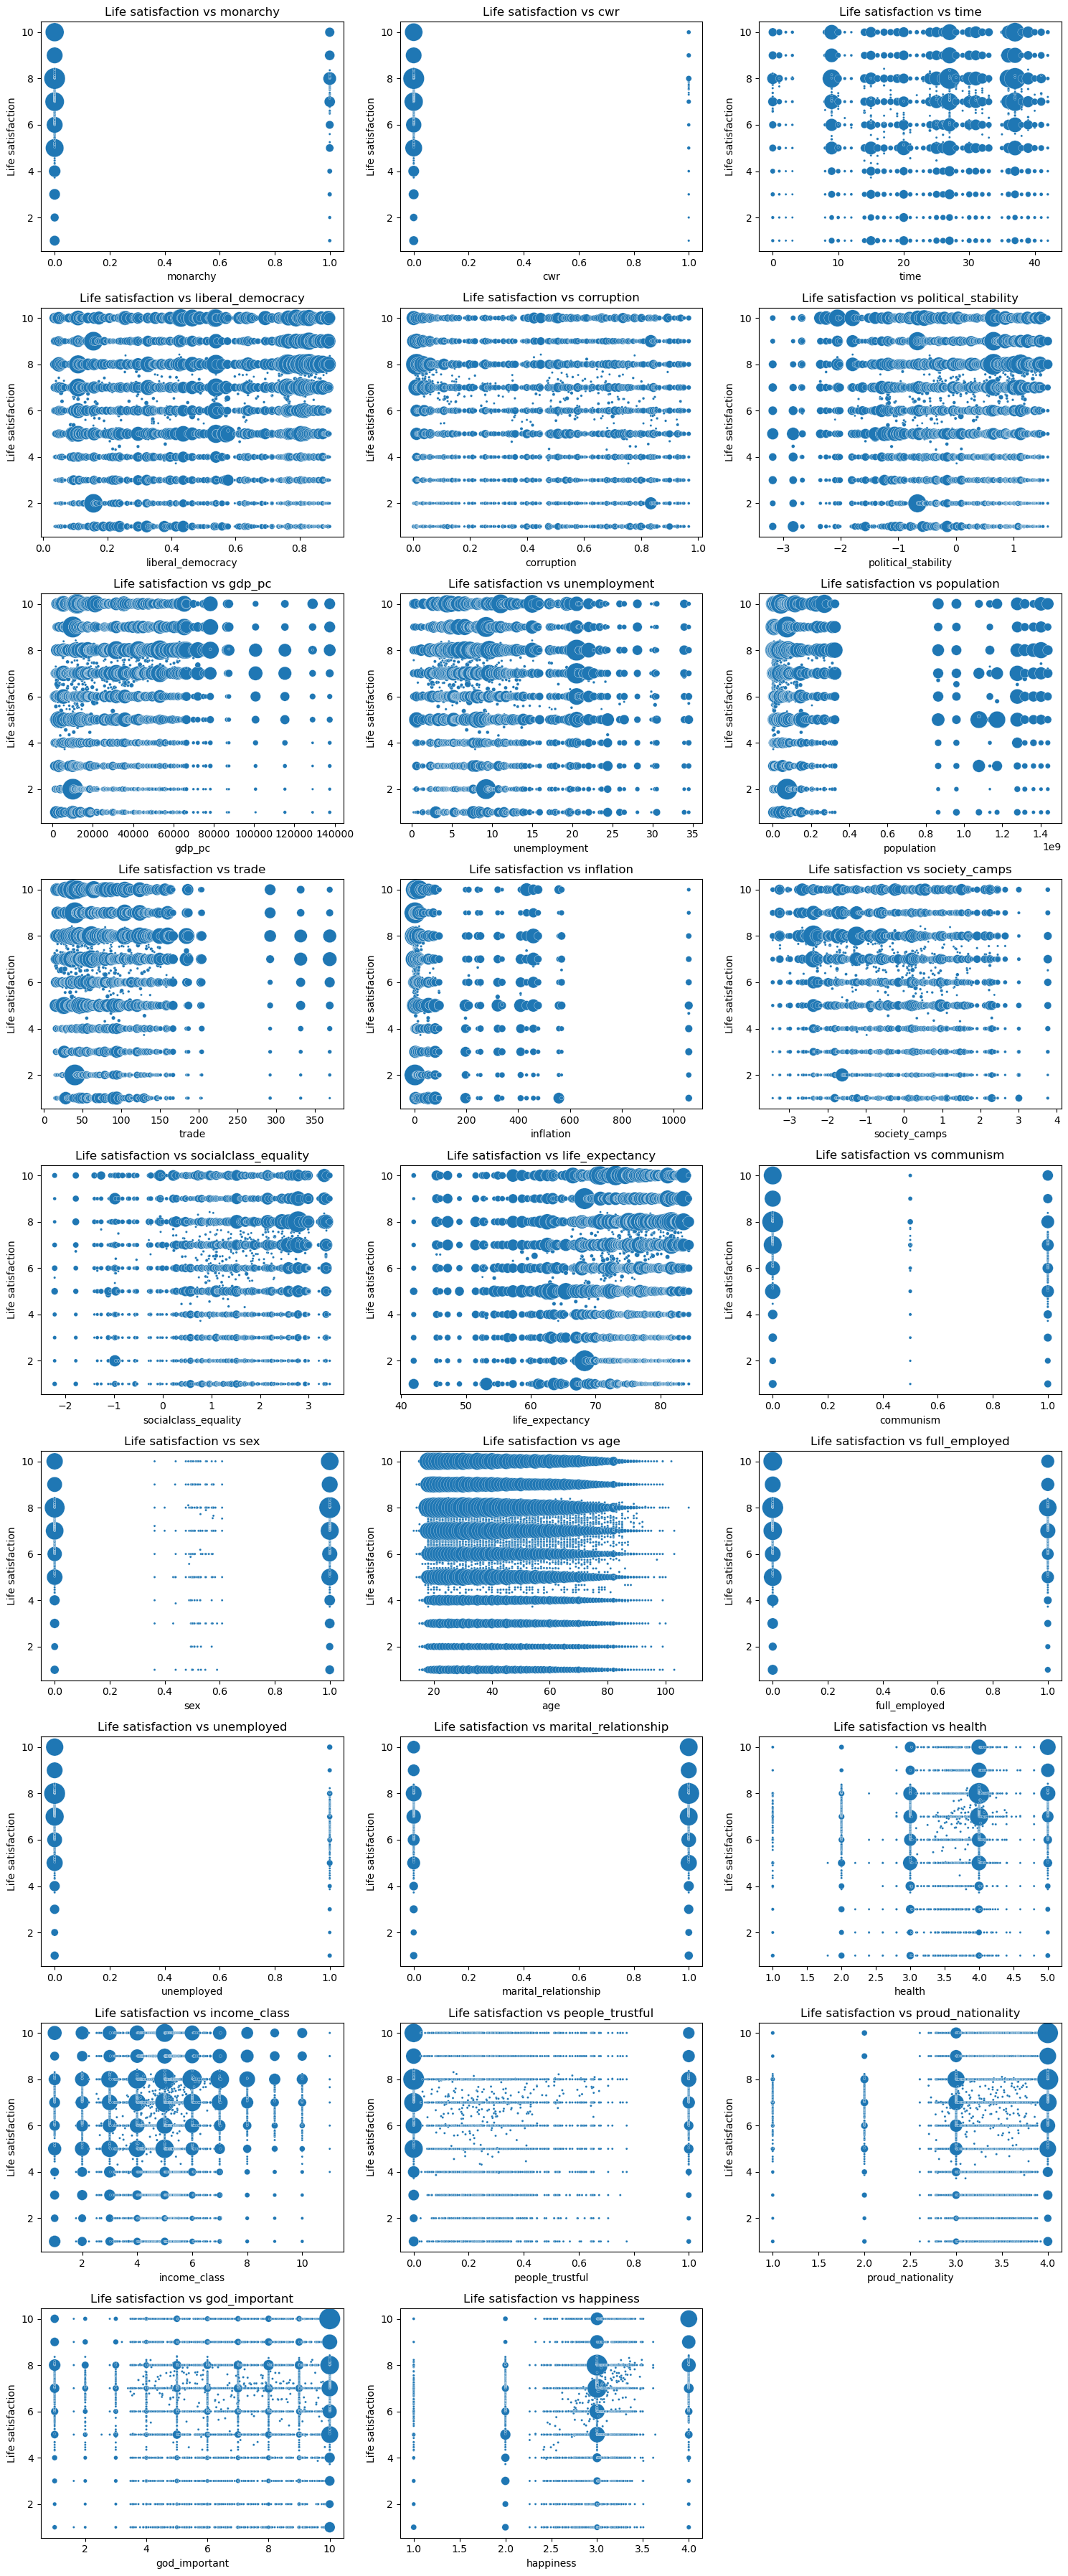


Summary of outliers per variable:
                Variable  Outlier count  Relative outliers (%)
0      life_satisfaction              0                    0.0
1               monarchy         119628                   20.9
2   monarchy_interaction         119628                   20.9
3                    cwr          23137                    4.0
4                   time              0                    0.0
5      liberal_democracy              0                    0.0
6             corruption              0                    0.0
7    political_stability           2325                    0.4
8             log_gdp_pc           1500                    0.3
9         log_population           2007                    0.4
10             log_trade           6596                    1.2
11             inflation          58979                   10.3
12          unemployment          40125                    7.0
13         society_camps           2415                    0.4
14  socialclass_equa

In [35]:
#Part 12: Inspect data

# Create a pivot table
pivot_table = data_logged_scaled.pivot_table(index='country', columns='year', aggfunc='size', fill_value=0)

# Plot the heatmap
print("\nOverview of the data distribution over countries and years")
plt.figure(figsize=(30, 20))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt='d')
ax = plt.gca()
for label in ax.get_yticklabels():
    country = label.get_text()
    label.set_color('black')
plt.title('Data Distribution Over Countries and Years')
plt.ylabel('Country')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

#Define datasets with only the numeric variables
data_final_numeric = data_final.select_dtypes(include=['number'])
data_logged_numeric_scaled = data_logged_scaled.select_dtypes(include=['number'])

#The following function shows the correlation matrix,the VIF variables and displays the distrubution and outliers of the variables 
corr_and_VIF(df_scaled=data_logged_numeric_scaled, df=data_final_numeric, target='life_satisfaction') #function previously defined

In [3]:
##Part 13: Regression models 

#Create function to run a Linear Mixed-Effects Regression Model 
def re_regression(df, target, country_column='country', respondent_column='respondent', year_column='year', robust=True):
    
    #Create dataset with the control variables 
    controls = list(df.columns.difference([target, country_column, respondent_column, year_column]))
    control_vars = " + ".join(controls)
   
    # Random effects by country
    formula = f"{target} ~ {control_vars}"
    model = smf.mixedlm(formula, df, groups=df[country_column])
    result = model.fit(reml=robust)

    #Compute R²
    fixed_effects = result.fittedvalues
    y = df[target]
    ss_total = ((y - y.mean()) ** 2).sum()
    ss_residual = ((y - fixed_effects) ** 2).sum()
    r2 = 1 - (ss_residual / ss_total)

    #Compute adjusted R²
    n = len(df)
    p = len(result.params)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    #Display results 
    print(f"\nThe summary of the results looks like: \n{result.summary()}")
    print(f"\nThe R²: {round(r2, 3)}")
    print(f"The adjusted R²: {round(adjusted_r2, 3)}\n")
  
    #Extract coefficients and significance levels
    coefs = round(result.params, 3)
    pvalues = result.pvalues

    # Add significance levels based on p-values
    significance = pvalues.apply(lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '')
    coefs_with_significance = coefs.map(str) + significance

    results_df = pd.DataFrame({'Variable': coefs.index, 'Coefficients': coefs_with_significance})

    return results_df

#Create function for OLS regression with robus standard herrors
def OLS_robust(df, target, robust=True):
    #Clean column names to ensure they are valid for formulas
    df = df.rename(columns=lambda x: re.sub(r'\W+', '_', x))
    
    #Create dataset with the control variables 
    controls = list(df.columns.difference([target]))
    control_vars = " + ".join(controls)

    #OLS-regression
    formula = f"{target} ~ {control_vars}"
    model = smf.ols(formula, data=df).fit()

    # Adjust the standard errors to be robust to heteroskedasticity
    robust_model = model.get_robustcov_results(cov_type='HC3')
    print("\nOLS summary with robust SE:")
    print(robust_model.summary())


In [ ]:
##Part 14: Main regressions

#Delete variables corruption, socialclass_equality and life_expectancy from dataset due to multicollinearity issues. 
data_log_scal_dj = data_scal_log_dum.copy()
data_log_scal_dj = data_log_scal_dj.drop(columns={'corruption', 'socialclass_equality', 'life_expectancy', 'happiness', 'cwr'})

#Initialize empty dictionary to store the results in
results_regressions = {} 

#Run LMM-regression with entire dataset 
print("1: LMM-regression result with entire dataset:")
results_regressions[1] = re_regression(df=data_log_scal_dj, target='life_satisfaction') #function previously defined

#Run LLM-regression where CWR countries are left out of the monarchy and monarchy_interaction variable
df_monarchy_nocwr = data_logged_scaled.copy()
df_monarchy_nocwr = df_monarchy_nocwr.drop(columns={'corruption', 'socialclass_equality', 'life_expectancy', 'happiness', 'monarchy_interaction', 'cwr'})
df_monarchy_nocwr.loc[df_monarchy_nocwr['country'].isin(['Australia', 'Canada', 'New Zealand']), 'monarchy'] = 0
df_monarchy_nocwr['monarchy_interaction'] = df_monarchy_nocwr['monarchy'] * df_monarchy_nocwr['liberal_democracy']
print("\n\n2: LMM-regression result with entire dataset and CWR excluded from monarchy and monarchy_interaction:")
results_regressions[2] = re_regression(df=df_monarchy_nocwr, target='life_satisfaction') #function previously defined

#Run regression with all variables except the interaction variable
df_no_interaction = data_log_scal_dj.copy()
df_no_interaction = df_no_interaction.drop(columns={'monarchy_interaction'})
print("3: LMM-regression result without interaction variable:")
results_regressions[3] = re_regression(df=df_no_interaction, target='life_satisfaction') #function previously defined


1: LMM-regression result with entire dataset:


c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))



The summary of the results looks like: 
             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: life_satisfaction
No. Observations:  573067  Method:             REML             
No. Groups:        111     Scale:              0.7415           
Min. group size:   417     Log-Likelihood:     -728110.2447     
Max. group size:   16651   Converged:          Yes              
Mean group size:   5162.8                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -0.235                                     
age                  -0.009    0.001  -5.908 0.000 -0.011 -0.006
age2                  0.054    0.001  43.754 0.000  0.052  0.056
communism            -0.466    0.256  -1.819 0.069 -0.967  0.036
full_employed        -0.015    0.003  -5.549 0.000 -0.021 -0.01

c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))



The summary of the results looks like: 
             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: life_satisfaction
No. Observations:  573067  Method:             REML             
No. Groups:        111     Scale:              0.7417           
Min. group size:   417     Log-Likelihood:     -728198.8584     
Max. group size:   16651   Converged:          Yes              
Mean group size:   5162.8                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             0.243                                     
age                  -0.009    0.001  -5.839 0.000 -0.011 -0.006
age2                  0.054    0.001  43.612 0.000  0.051  0.056
communism            -0.438    0.247  -1.777 0.076 -0.922  0.045
full_employed        -0.015    0.003  -5.517 0.000 -0.021 -0.01

In [60]:
##Part 15: Regression analyses to check for overcontrol bias

#Run minimized regession with only life satisfaction and monarchy_interaction
print("\n\n4: LMM-regression result with only life satisfaction and monarchy_interaction: ")
results_regressions[4] = re_regression(df=data_log_scal_dj[['country', 'life_satisfaction', 'monarchy_interaction']], target='life_satisfaction') #function previously defined

#Run minimized regession with only life satisfaction, moanrchy_interaction, monarchy and democracy
print("\n\n5: LMM-regression result with only life satisfaction, monarchy_interaction, monarchy and democracy: ")
results_regressions[5] = re_regression(df=data_log_scal_dj[['country', 'life_satisfaction', 'monarchy_interaction', 'monarchy', 'liberal_democracy']], target='life_satisfaction') #function previously defined

#Run LMM analyses without  any of the possile theorized mediators 
mediators = ['people_trustful', 'proud_nationality', 'society_camps', 'log_trade', 'political_stability']
variables_include = [col for col in data_log_scal_dj.columns if col not in mediators]
reduced_data = data_log_scal_dj[variables_include]
print("\n\n6: LMM-regression result without any of the possible theorized mediators")
results_regressions[6] = re_regression(df=reduced_data, target='life_satisfaction') #function previously defined

#Run LLM analysis while leaving the possible mediators one-for-one out
mediators = ['people_trustful', 'proud_nationality', 'society_camps', 'log_trade', 'political_stability']
for i, med in zip(range(7, 12), mediators):
    data_med = data_log_scal_dj.copy()
    data_med = data_med.drop(columns=[med])
    print(f"\n\n{i}: LMM-regression result without {med} in dataset")
    results_regressions[i] = re_regression(df=data_med, target='life_satisfaction') #Function perviously defined



4: LMM-regression result with only life satisfaction and monarchy_interaction: 

The summary of the results looks like: 
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: life_satisfaction
No. Observations: 573067  Method:             REML             
No. Groups:       111     Scale:              0.8835           
Min. group size:  417     Log-Likelihood:     -778034.3348     
Max. group size:  16651   Converged:          Yes              
Mean group size:  5162.8                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.030    0.036 -0.822 0.411 -0.101  0.041
monarchy_interaction  0.410    0.027 14.912 0.000  0.356  0.464
Group Var             0.145    0.021                           


The R²: 0.117
The adjusted R²: 0.117



5: LMM-regressio

In [62]:
##Part 16: Robustness analyses

#Run LLM-regression with happiness instead of life satisfaction
data_log_scal_dj_happiness = data_logged_scaled.copy()
data_log_scal_dj_happiness = data_log_scal_dj_happiness.drop(columns={'corruption', 'socialclass_equality', 'life_expectancy', 'life_satisfaction', 'cwr'})
print("\n\n12: LMM-regression result on happiness instead of life satisfaction:")
results_regressions[12] = re_regression(df=data_log_scal_dj_happiness, target='happiness') #function previously defined

#Robustness analyses on subsets of the dataset
#Men
subset_condition_men = lambda df: df['sex'] == 0
df_men = data_log_scal_dj[subset_condition_men(data_log_scal_dj)]
df_men = df_men.drop(columns=['sex'])
print("\n\n13: LMM-regression result subset for only men")
results_regressions[13] = re_regression(df=df_men, target='life_satisfaction') #function previously defined

#Women
subset_condition_women = lambda df: df['sex'] ==  1
df_women = data_log_scal_dj[subset_condition_women(data_log_scal_dj)]
df_women = df_women.drop(columns=['sex'])
print("\n\n14: LMM-regression result subset for only women")
results_regressions[14] = re_regression(df=df_women, target='life_satisfaction') #function previously defined

#Youngest half
subset_condition_young = lambda df: df['age'] < df['age'].median()
df_young = data_log_scal_dj[subset_condition_young(data_log_scal_dj)]
df_young = df_young.drop(columns=['age'])
print("\n\n15: LMM-regression result subset for 50% youngest people")
results_regressions[15] = re_regression(df=df_young, target='life_satisfaction') #function previously defined

#Oldest half
subset_condition_old = lambda df: df['age'] >= df['age'].median()
df_old = data_log_scal_dj[subset_condition_old(data_log_scal_dj)]
df_old = df_old.drop(columns=['age'])
print("\n\n16: LMM-regression result subset for 50% oldest people")
results_regressions[16] = re_regression(df=df_old, target='life_satisfaction') #function previously defined

#god_important
subset_condition_god = lambda df: df['god_important'] >= df['god_important'].max()
df_god = data_log_scal_dj[subset_condition_god(data_log_scal_dj)]
df_god = df_god.drop(columns=['god_important'])
print("\n\n17: LMM-regression result subset for the most religous people")
results_regressions[17] = re_regression(df=df_god, target='life_satisfaction') #function previously defined





12: LMM-regression result on happiness instead of life satisfaction:

The summary of the results looks like: 
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   happiness   
No. Observations:   573067    Method:               REML        
No. Groups:         111       Scale:                0.7552      
Min. group size:    417       Log-Likelihood:       -733173.1482
Max. group size:    16651     Converged:            Yes         
Mean group size:    5162.8                                      
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -0.167    0.065  -2.568 0.010 -0.294 -0.039
age                  -0.048    0.001 -32.953 0.000 -0.051 -0.046
age2                  0.054    0.001  43.443 0.000  0.052  0.057
communism            -0.186    0.108  -1.728 0.084 -0.397

In [63]:
#Part 17: print all the regression results into one table

# Initialize an empty list to collect all results
all_results = []

# Iterate through each model (key-value pair)
for model, df in results_regressions.items():
    # Set the model name as a column and append to the results list
    df['Model'] = model
    all_results.append(df)

# Concatenate all results into one DataFrame
df_results = pd.concat(all_results, axis=0)
# Pivot the table so that each model becomes a separate column
df_pivot = df_results.pivot(index='Variable', columns='Model', values='Coefficients')
# Reset index to make 'Variable' a column again
df_pivot.reset_index(inplace=True)

print(df_pivot)

Model              Variable          1          2          3         4  \
0                 Group Var   1.389***    1.49***   1.257***  0.164***   
1                 Intercept     -0.236     -0.253     -0.236     -0.03   
2                       age  -0.009***  -0.009***  -0.009***       NaN   
3                      age2   0.055***   0.055***   0.055***       NaN   
4                 communism     -0.418     -0.406     -0.391       NaN   
5             full_employed  -0.012***  -0.012***  -0.012***       NaN   
6             god_important   0.085***   0.085***   0.085***       NaN   
7                    health   0.261***   0.261***   0.261***       NaN   
8              income_class   0.137***   0.137***   0.136***       NaN   
9                 inflation        0.0      0.001        0.0       NaN   
10        liberal_democracy   0.026***   0.025***   0.038***       NaN   
11               log_gdp_pc    0.26***    0.26***   0.258***       NaN   
12           log_population  -1.015***

In [42]:
##Part 18: Extreme Bounds Analysis as by Oster (2019)

# Define the values for the regression R-squared and beta (without controls)
R_controls = 0.249           # R-squared value from the regression with controls
R_no_controls = 0.117       # R-squared value from the regression without controls

# Calculate the coefficient of proportionality (delta) using the formula
delta = (1 - R_controls) / (R_controls - R_no_controls)

# Print the result
print(f"The coefficient of proportionality (delta) is: {round(delta, 3)}")

The coefficient of proportionality (delta) is: 5.689


In [90]:
#First download the final_data file 
#Convert 'year' and 'repsondent'columns
data_final['year'] = data_final['year'].fillna(0).astype(int)  
data_final['respondent'] = data_final['respondent'].astype(float)

# Save as a Stata file (.dta)
file_1 = 'data_complete_updated.dta'
data_final.to_stata(file_1, version=117)

# Generate a download link
FileLink(file_1)

c:\Users\Lenovo\Downloads\data_complete_updated.dta

In [91]:
##Part 20: download logged and scaled data
data_logged_scaled['year'] = data_logged_scaled['year'].fillna(0).astype(int)
data_logged_scaled['respondent'] = data_logged_scaled['respondent'].astype(float)

# Save as a Stata file (.dta)
file_2 = "data_logged_scaled_updated.dta"
data_logged_scaled.to_stata(file_2, version=117)

# Generate a download link
FileLink(file_2)

c:\Users\Lenovo\Downloads\data_logged_scaled_updated.dta

In [27]:
#Load statafile 
df_graafland = pd.read_stata(r"C:\Users\Lenovo\Downloads\Data_wave.dta")
df_fromstata = pd.read_stata(r"C:\Users\Lenovo\Downloads\data_logged_scaled_updated.dta")

data_wave = pd.merge(df_fromstata, df_graafland, on='index', how='left')

In [30]:
print(data_wave.columns)

Index(['index', 'country', 'year', 'respondent', 'life_satisfaction',
       'monarchy', 'monarchy_interaction', 'cwr', 'time', 'liberal_democracy',
       'corruption', 'political_stability', 'log_gdp_pc', 'log_population',
       'log_trade', 'inflation', 'unemployment', 'society_camps',
       'socialclass_equality', 'life_expectancy', 'communism', 'sex', 'age',
       'age2', 'full_employed', 'unemployed', 'marital_relationship', 'health',
       'income_class', 'people_trustful', 'proud_nationality', 'god_important',
       'happiness', 'wave'],
      dtype='object')


In [39]:
data_use = data_wave.copy()

re_regression(df=data_use[['country', 'year', 'respondent', 'monarchy_interaction', 'life_satisfaction']], target='life_satisfaction') #function previously defined


The summary of the results looks like: 
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: life_satisfaction
No. Observations: 573067  Method:             REML             
No. Groups:       111     Scale:              0.8835           
Min. group size:  417     Log-Likelihood:     -778034.3348     
Max. group size:  16651   Converged:          Yes              
Mean group size:  5162.8                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.030    0.036 -0.822 0.411 -0.101  0.041
monarchy_interaction  0.410    0.027 14.912 0.000  0.356  0.464
Group Var             0.145    0.021                           


The R²: 0.117
The adjusted R²: 0.117



,Variable,Coefficients
Intercept,Intercept,-0.03
monarchy_interaction,monarchy_interaction,0.41***
Group Var,Group Var,0.164***
